In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2535730/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                             | 0/50000 [00:00<?, ?it/s]

  8%|█████████▎                                                                                                     | 4216/50000 [00:00<00:01, 42153.21it/s]

 17%|██████████████████▊                                                                                            | 8493/50000 [00:00<00:00, 42512.75it/s]

 26%|████████████████████████████▏                                                                                 | 12831/50000 [00:00<00:00, 42904.96it/s]

 34%|█████████████████████████████████████▉                                                                        | 17243/50000 [00:00<00:00, 43383.26it/s]

 43%|███████████████████████████████████████████████▍                                                              | 21582/50000 [00:00<00:00, 43126.22it/s]

 52%|█████████████████████████████████████████████████████████                                                     | 25918/50000 [00:00<00:00, 43202.44it/s]

 61%|██████████████████████████████████████████████████████████████████▋                                           | 30327/50000 [00:00<00:00, 43490.50it/s]

 69%|████████████████████████████████████████████████████████████████████████████▎                                 | 34689/50000 [00:00<00:00, 43529.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▉                        | 39043/50000 [00:00<00:00, 43355.41it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████▌              | 43450/50000 [00:01<00:00, 43572.94it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 47864/50000 [00:01<00:00, 43745.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43275.94it/s]

Files already downloaded and verified


  0%|                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 43%|███████████████████████████████████████████████▌                                                               | 4283/10000 [00:00<00:00, 42824.02it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████▍               | 8598/10000 [00:00<00:00, 43010.96it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 42436.71it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 ks6467y3


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ks6467y3:best, 58.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.2


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                               | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                      | 1/313 [00:00<02:38,  1.97it/s]

  4%|█████▎                                                                                                                | 14/313 [00:00<00:10, 29.73it/s]

  8%|█████████▊                                                                                                            | 26/313 [00:00<00:05, 51.04it/s]

 12%|██████████████▋                                                                                                       | 39/313 [00:00<00:03, 70.39it/s]

 17%|███████████████████▉                                                                                                  | 53/313 [00:00<00:02, 87.26it/s]

 21%|█████████████████████████▎                                                                                            | 67/313 [00:01<00:02, 99.67it/s]

 26%|██████████████████████████████▎                                                                                      | 81/313 [00:01<00:02, 108.60it/s]

 30%|███████████████████████████████████▏                                                                                 | 94/313 [00:01<00:01, 114.54it/s]

 35%|████████████████████████████████████████                                                                            | 108/313 [00:01<00:01, 119.21it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 122/313 [00:01<00:01, 122.55it/s]

 43%|██████████████████████████████████████████████████▍                                                                 | 136/313 [00:01<00:01, 124.89it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 150/313 [00:01<00:01, 126.57it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 164/313 [00:01<00:01, 127.75it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                  | 178/313 [00:01<00:01, 128.50it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                            | 192/313 [00:01<00:00, 129.13it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                       | 206/313 [00:02<00:00, 129.55it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                  | 220/313 [00:02<00:00, 130.23it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                             | 234/313 [00:02<00:00, 130.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                        | 248/313 [00:02<00:00, 130.82it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                   | 262/313 [00:02<00:00, 130.83it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 276/313 [00:02<00:00, 131.02it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 290/313 [00:02<00:00, 131.14it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 304/313 [00:02<00:00, 131.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 105.61it/s]

train - OK


  0%|                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                      | 1/79 [00:00<00:08,  9.73it/s]

 19%|██████████████████████▌                                                                                                | 15/79 [00:00<00:00, 81.96it/s]

 37%|███████████████████████████████████████████▎                                                                          | 29/79 [00:00<00:00, 104.43it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 43/79 [00:00<00:00, 115.01it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 57/79 [00:00<00:00, 120.83it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 71/79 [00:00<00:00, 124.43it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 103.14it/s]

val - OK


  0%|                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                      | 1/79 [00:00<00:08,  9.05it/s]

 19%|██████████████████████▌                                                                                                | 15/79 [00:00<00:00, 79.55it/s]

 37%|███████████████████████████████████████████▎                                                                          | 29/79 [00:00<00:00, 102.87it/s]

 54%|████████████████████████████████████████████████████████████████▏                                                     | 43/79 [00:00<00:00, 113.96it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 57/79 [00:00<00:00, 120.21it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 71/79 [00:00<00:00, 124.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 106.26it/s]

test InD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

 13%|███████████████▏                                                                                                     | 13/100 [00:00<00:00, 129.90it/s]

 27%|███████████████████████████████▌                                                                                     | 27/100 [00:00<00:00, 130.70it/s]

 41%|███████████████████████████████████████████████▉                                                                     | 41/100 [00:00<00:00, 131.01it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                    | 55/100 [00:00<00:00, 131.21it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 69/100 [00:00<00:00, 131.27it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 83/100 [00:00<00:00, 131.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 97/100 [00:00<00:00, 131.41it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 131.16it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 3, 32, 32) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(12800, 3, 32, 32) (12800, 3, 32, 32) (12800, 512) (12800, 10)


In [11]:
# create tsne embeddings
n = ind_emb.shape[0]
all_emb = ind_emb
all_lgt = ind_lgt
if ood_str:
    all_emb = np.concatenate([all_emb, ood_emb], axis=0)
    all_lgt = np.concatenate([all_lgt, ood_lgt], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb2d = tsne.fit_transform(all_emb)
ind_emb2d = np.array(all_emb2d[:n], order='C').astype(np.float32)
ood_emb2d = np.array(all_emb2d[n:], order='C').astype(np.float32)
print(ind_emb2d.shape, ood_emb2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


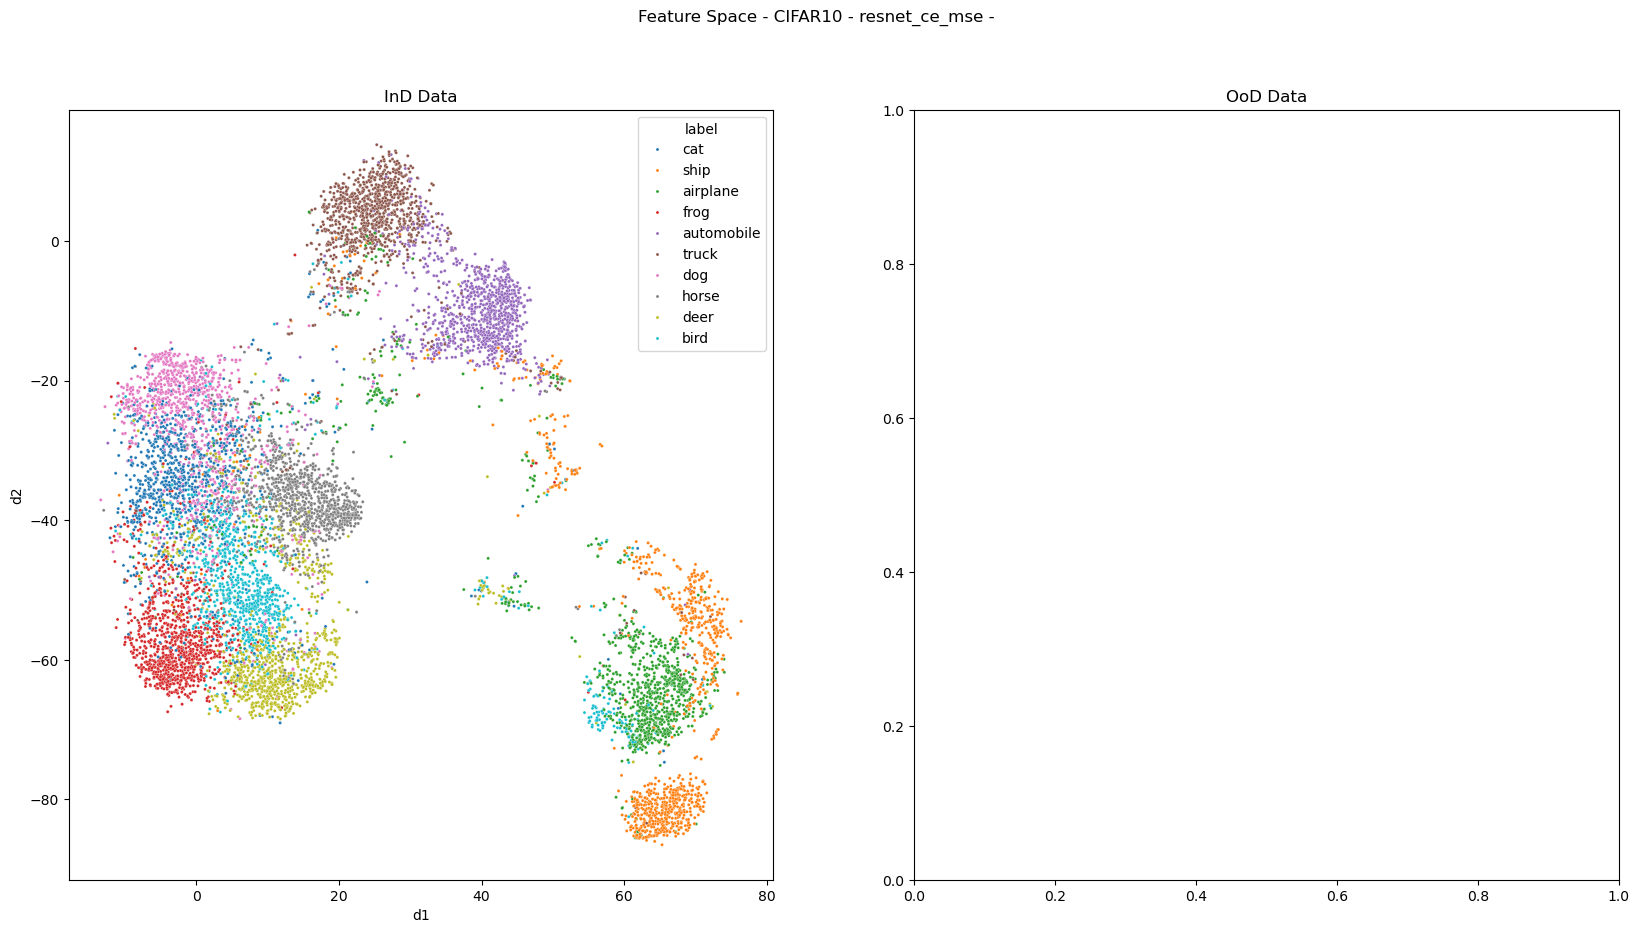

In [12]:
# plot feature space
df_emb2d = pd.DataFrame()
d1, d2 = ind_emb2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

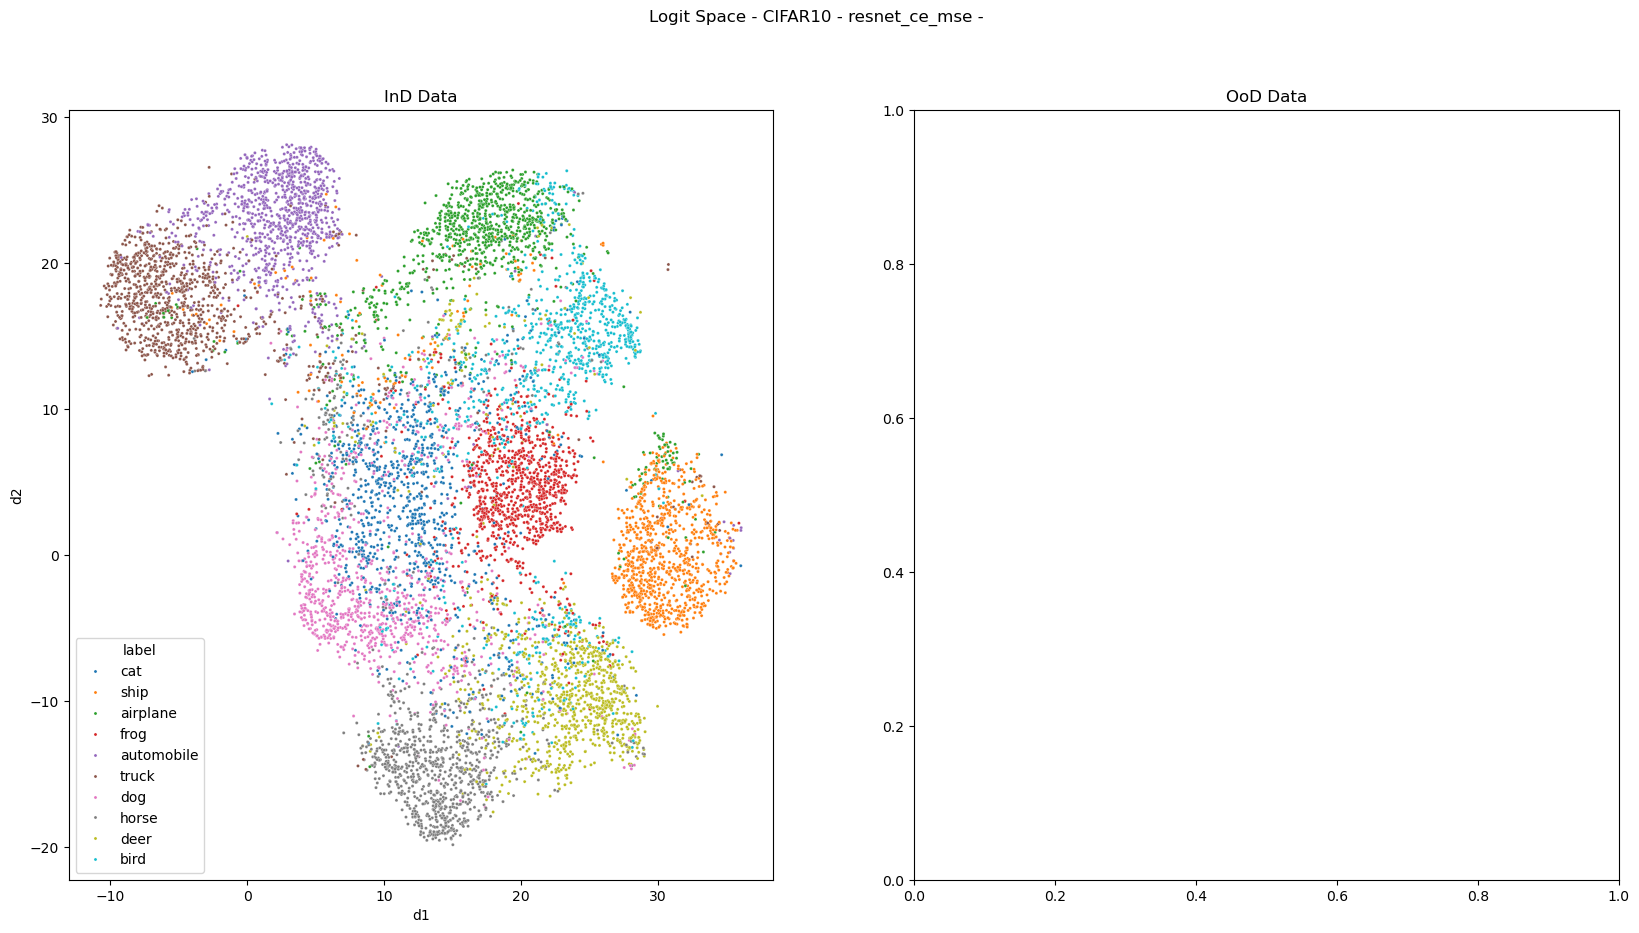

In [13]:
# plot logit space
df_lgt2d = pd.DataFrame()
d1, d2 = ind_lgt2d.T
df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    df_lgt2d = pd.concat([df_lgt2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt2d[(df_lgt2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:02,  1.30it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.15it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:02<00:00,  1.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

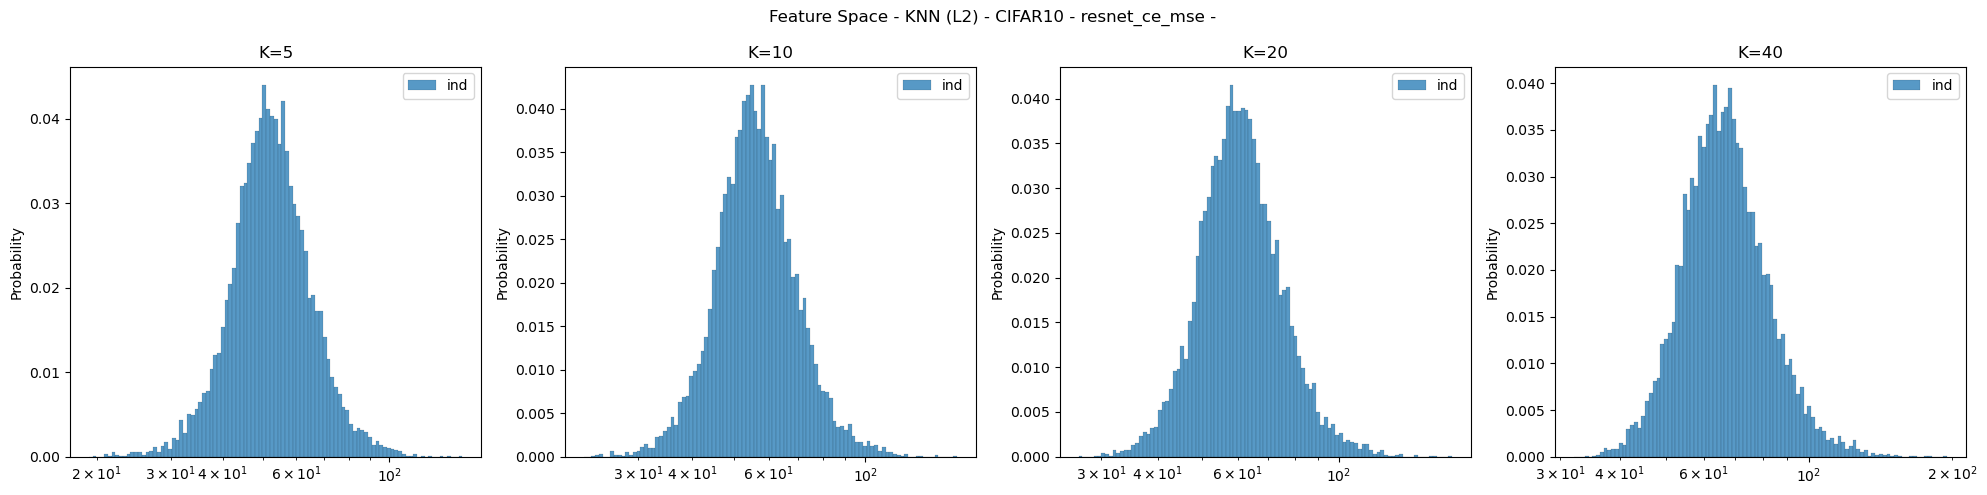

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:02,  1.33it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.32it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:02<00:00,  1.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

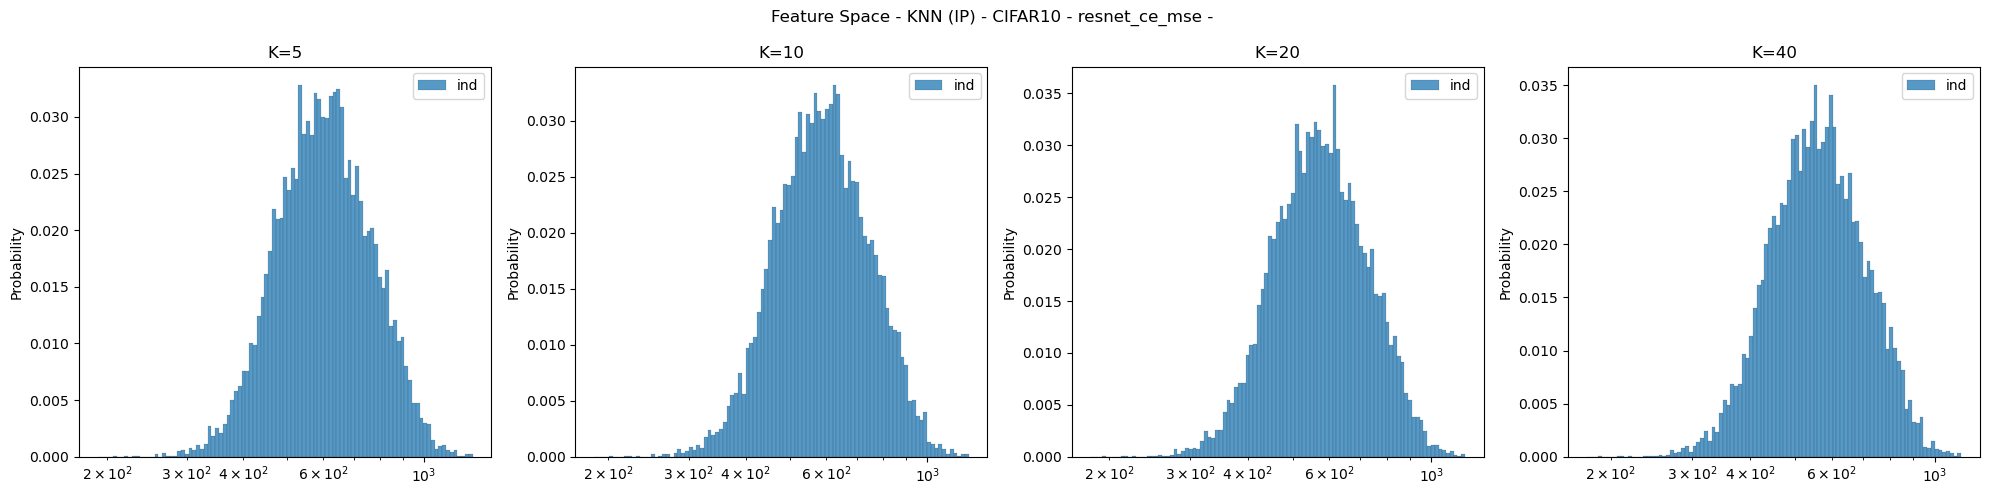

In [15]:
# plot knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  6.16it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  3.92it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  4.34it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.18it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.27it/s]

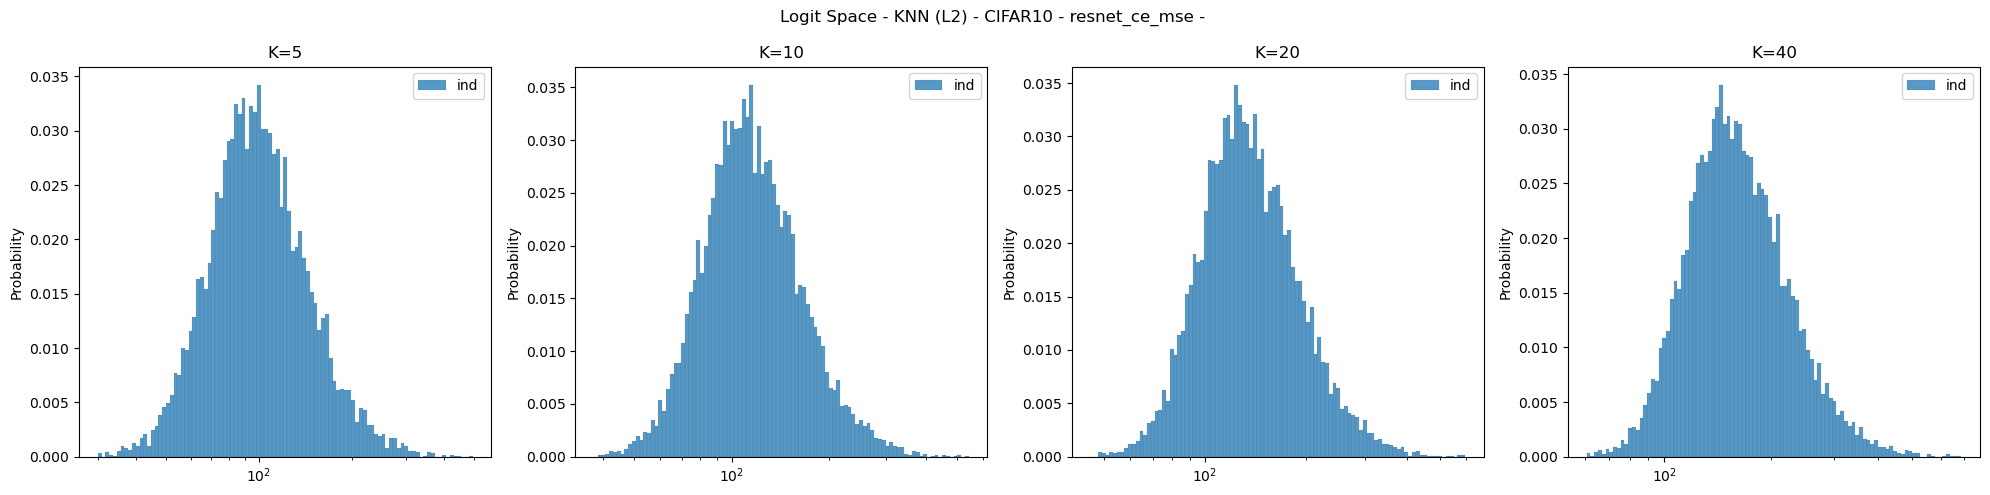

In [16]:
# plot knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  6.73it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  6.50it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  6.01it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.53it/s]

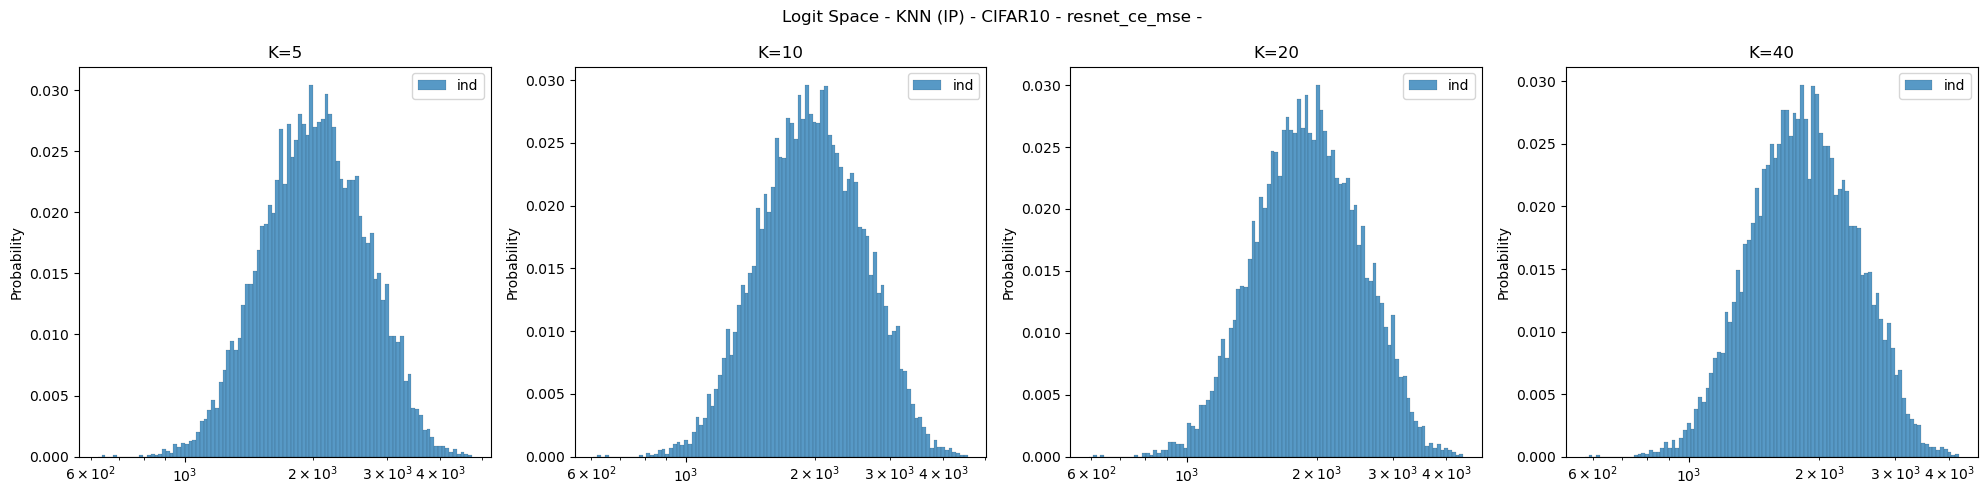

In [17]:
# plot knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

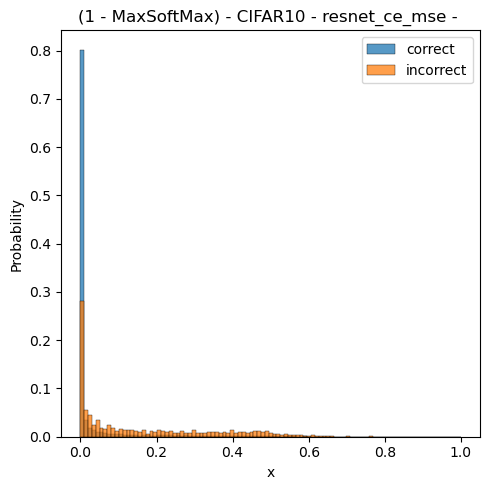

In [18]:
# plot (1 - maxsoftmax) distribution
ind_prob = np.exp(ind_lgt.astype(np.float64)) / np.exp(ind_lgt.astype(np.float64)).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt.astype(np.float64)) / np.exp(ood_lgt.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

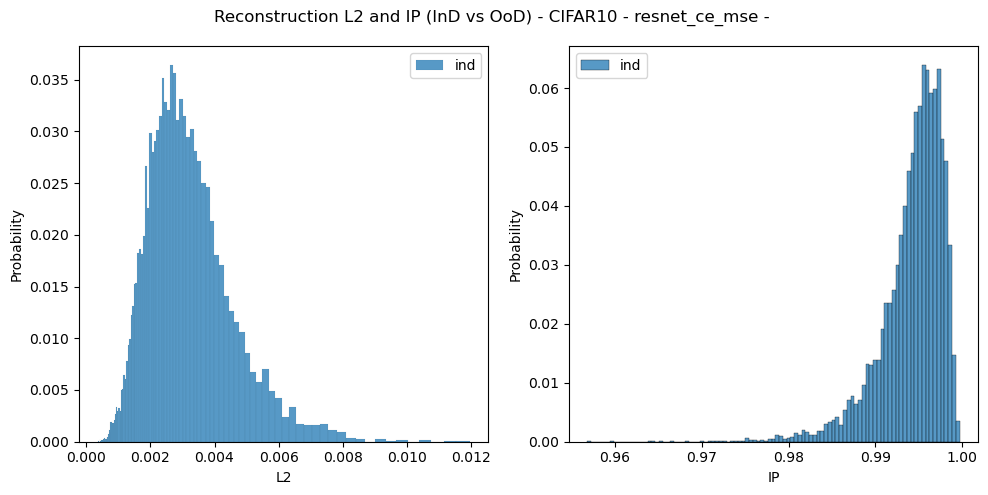

In [19]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)
# store
_df = pd.DataFrame(dict(target=ind_tgt, rcn_l2=ind_rcn_l2, rcn_ip=ind_rcn_ip, source="ind"))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(target=ood_tgt, rcn_l2=ood_rcn_l2, rcn_ip=ood_rcn_ip, source="ood"))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax2)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ood", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ood", stat="probability", bins=bins_rcn_ip, ax=ax2)

ax1.legend()
ax2.legend()
ax1.set_xlabel("L2")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()